## 研究用　主成分分析
研究で用いる主成分分析のプログラム
ユーザーが事前に用意したアイデア群をPCAにかける
kmeansでクラスタリングして第二主成分の影響をもっとも受けているクラスタを指定
画像認識APIから返ってきた単語を分類器にかけてそのクラスタに分類されたらそのクラスタを表示

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#
# Author: Yusuke Yamamoto
# Email: yusuke@hontolab.org
# URL: https://hontolab.org/
# Licence: MIT License

''' BERTを使った文のベクトル化．
    東北大学の乾研究室が構築したBERTモデルを使用．
    MeCabを用いて構築されたモデルであること，公式のtransformersにデフォルトで
    組み込まれていることが採用の理由．
'''
import numpy as np
import torch
from transformers import BertJapaneseTokenizer, BertModel

BERT_MODEL_PATH = "cl-tohoku/bert-base-japanese-whole-word-masking"


class BertVectorizer():
    ''' BERTを用いて文をベクトル化するクラス
    '''
    def __init__(self, bert_path=BERT_MODEL_PATH):
        self.bert = BertModel.from_pretrained(bert_path)
        self.tokenizer = BertJapaneseTokenizer.from_pretrained(bert_path)


    def vectorize(self, texts, pooling_strategy="REDUCE_MEAN"):
        # わかちがき
        encoded_data = self.tokenizer.batch_encode_plus(
            texts, pad_to_max_length=True, add_special_tokens=True)

        # BERT適用
        outputs = self.bert(torch.tensor(encoded_data['input_ids']))

        # BERTの隠れ層の最終レイヤーを取得
        last_hidden_layers = outputs[0]

        if pooling_strategy == "REDUCE_MEAN":
            return torch.mean(last_hidden_layers, dim=1).detach().numpy()
        elif pooling_strategy == "REDUCE_MAX":
            vector, _ = torch.max(last_hidden_layers, dim=1)
            return vector.detach().numpy()
        elif pooling_strategy == "REDUCE_MEAN_MAX":
            max_vector, _ = torch.max(last_hidden_layers, dim=1)
            mean_vector = torch.mean(last_hidden_layers, dim=1)
            return torch.cat((max_vector, mean_vector), dim=1).detach().numpy()
        elif pooling_strategy == "CLS_TOKEN":
            return last_hidden_layers[:, 0, :].detach().numpy()
        else:
            raise ValueError("specify valid pooling_strategy: {REDUCE_MEAN, REDUCE_MAX, REDUCE_MEAN_MAX, CLS_TOKEN}")

            
def cosine_similarity(v1, v2):
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    inner_product = np.dot(v1, v2)
    return inner_product / (norm1 * norm2)


if __name__ == '__main__':
    texts = ["夜の街にオープンしているワイナリーの入り口",
             "踏切の近くにワイナリーが開店している",
             "野球選手のフォームの確認をしている"]

    vectorizer = BertVectorizer()

    # textsに格納された複数の文をバッチでベクトル化
    vectors = vectorizer.vectorize(texts, "CLS_TOKEN")

    # コサイン類似度計算（文0と文2のベクトルの類似度）
    cosine_similarity(vectors[0], vectors[2])



/Users/wyuki/opt/anaconda3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1767: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [2]:
vectors

array([[-0.5465305 , -0.52534544, -0.11975133, ..., -0.7519278 ,
         0.13584745,  0.22590585],
       [-0.29321605, -0.91727006, -0.23012532, ..., -0.44396135,
        -0.15141895,  0.29821   ],
       [-0.1337141 ,  0.3497174 , -0.23502728, ...,  0.15667285,
        -0.12281869, -0.05377182]], dtype=float32)

In [3]:
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [4]:
with open('/Users/wyuki/研究/ideas.csv') as f:
    test_data = f.readlines()
    print(test_data)


['\ufeffガンダムみたいな乗り物\n', '美容院\n', '登り棒\n', 'ソーシャルディスタンスを保てる\n', '乗った人の犯罪係数がわかる\n', 'Wi-Fiと充電機能付き\n', '新しいエレベーター\n', '図書館\n', '動くドライブスルー\n', '家から遠隔操作できる車\n', 'いるべき車線がARで表示される\n', '動く家\n', '方向音痴でも運転できる\n', '着る車\n', 'ドラえもんみたいに３mm浮いている\n', 'ベッド\n', '18歳以下でも運転できる\n', '外の景色を画像認識して何か教えてくれる\n', 'イス\n', 'タイヤが球体\n', '水陸空両用車\n', '遊牧民\n', '乗れば空間充電される\n', '無人デリバリー専用車\n', '気まずくならない車\n', 'いいと思った窓の景色を撮ってくれる\n', 'ブレスト車\n', 'タイムマシン\n', '動く道路\n', '道路がポイント切り替え\n', '優しい気持ちになれる車\n', '街中の建物にタイヤをつける\n', '自転車についてくる荷物カゴ\n', '車っぽい買い物袋\n', '消臭車\n', '絶対にドライブデートが成功する\n', 'しりぞけあう車\n', '道路でスキー\n', 'ドローンで運ばれる\n', '人力\n', 'UFOキャッチャー\n', 'どこでもドア\n', 'カラオケ\n', '渋滞の解消\n', '光の速さで動く\n', '街中ジェットコースター\n', 'フロントにいろいろ表示\n', 'くぐれる\n', 'またげる\n', '馬\n', 'カスタマイズできる車\n', '外側が液晶画面\n', '飛んでいるように感じる車\n', '悪路をなんとかしてくれる\n', 'ついてくる影\n', 'ついてくる傘\n', 'どこでも止まれる電車\n', '折り畳める\n', '外の広告とAmazonが連動\n', '着せ替えできる\n', '時間ぴったりの動画が流れる\n', '助手席がDJ\n', '夜は荷物うを勝手に運ぶ車\n', '椅子が増える\n', 'エンジンからオーダーメイドの車\n', '野生のタクシー\n', '乗った車が自分のものになる\n', 'ぽいぽいカプセル\n', 'たくさんの

In [5]:
new_Lines = []
for line in test_data:
    new_Lines.append(line.replace('\ufeff', '').replace('\n',''))
print(new_Lines)

['ガンダムみたいな乗り物', '美容院', '登り棒', 'ソーシャルディスタンスを保てる', '乗った人の犯罪係数がわかる', 'Wi-Fiと充電機能付き', '新しいエレベーター', '図書館', '動くドライブスルー', '家から遠隔操作できる車', 'いるべき車線がARで表示される', '動く家', '方向音痴でも運転できる', '着る車', 'ドラえもんみたいに３mm浮いている', 'ベッド', '18歳以下でも運転できる', '外の景色を画像認識して何か教えてくれる', 'イス', 'タイヤが球体', '水陸空両用車', '遊牧民', '乗れば空間充電される', '無人デリバリー専用車', '気まずくならない車', 'いいと思った窓の景色を撮ってくれる', 'ブレスト車', 'タイムマシン', '動く道路', '道路がポイント切り替え', '優しい気持ちになれる車', '街中の建物にタイヤをつける', '自転車についてくる荷物カゴ', '車っぽい買い物袋', '消臭車', '絶対にドライブデートが成功する', 'しりぞけあう車', '道路でスキー', 'ドローンで運ばれる', '人力', 'UFOキャッチャー', 'どこでもドア', 'カラオケ', '渋滞の解消', '光の速さで動く', '街中ジェットコースター', 'フロントにいろいろ表示', 'くぐれる', 'またげる', '馬', 'カスタマイズできる車', '外側が液晶画面', '飛んでいるように感じる車', '悪路をなんとかしてくれる', 'ついてくる影', 'ついてくる傘', 'どこでも止まれる電車', '折り畳める', '外の広告とAmazonが連動', '着せ替えできる', '時間ぴったりの動画が流れる', '助手席がDJ', '夜は荷物うを勝手に運ぶ車', '椅子が増える', 'エンジンからオーダーメイドの車', '野生のタクシー', '乗った車が自分のものになる', 'ぽいぽいカプセル', 'たくさんの車でグリッドコンピューティング', '窓ガラスが液晶ディスプレイ', '実際より速く感じる車', 'トイレ', '窓に電子広告', '乗ってる人全員で運転', '道路を舗装する車', '道路を掃除する車', '酔わない車', 'パーソナルモビリティが合体', '目的地がランダムなタク

In [6]:
idea_texts = ['ガンダムみたいな乗り物', '美容院', '登り棒', 'ソーシャルディスタンスを保てる', '乗った人の犯罪係数がわかる', 'Wi-Fiと充電機能付き', '新しいエレベーター', '図書館', '動くドライブスルー', '家から遠隔操作できる車', 'いるべき車線がARで表示される', '動く家', '方向音痴でも運転できる', '着る車', 'ドラえもんみたいに３mm浮いている', 'ベッド', '18歳以下でも運転できる', '外の景色を画像認識して何か教えてくれる', 'イス', 'タイヤが球体', '水陸空両用車', '遊牧民', '乗れば空間充電される', '無人デリバリー専用車', '気まずくならない車', 'いいと思った窓の景色を撮ってくれる', 'ブレスト車', 'タイムマシン', '動く道路', '道路がポイント切り替え', '優しい気持ちになれる車', '街中の建物にタイヤをつける', '自転車についてくる荷物カゴ', '車っぽい買い物袋', '消臭車', '絶対にドライブデートが成功する', 'しりぞけあう車', '道路でスキー', 'ドローンで運ばれる', '人力', 'UFOキャッチャー', 'どこでもドア', 'カラオケ', '渋滞の解消', '光の速さで動く', '街中ジェットコースター', 'フロントにいろいろ表示', 'くぐれる', 'またげる', '馬', 'カスタマイズできる車', '外側が液晶画面', '飛んでいるように感じる車', '悪路をなんとかしてくれる', 'ついてくる影', 'ついてくる傘', 'どこでも止まれる電車', '折り畳める', '外の広告とAmazonが連動', '着せ替えできる', '時間ぴったりの動画が流れる', '助手席がDJ', '夜は荷物うを勝手に運ぶ車', '椅子が増える', 'エンジンからオーダーメイドの車', '野生のタクシー', '乗った車が自分のものになる', 'ぽいぽいカプセル', 'たくさんの車でグリッドコンピューティング', '窓ガラスが液晶ディスプレイ', '実際より速く感じる車', 'トイレ', '窓に電子広告', '乗ってる人全員で運転', '道路を舗装する車', '道路を掃除する車', '酔わない車', 'パーソナルモビリティが合体', '目的地がランダムなタクシー', '買ったものを家に着くまでに届けてくれる', '車ごと電車に乗る', 'ウォークスルー', '部屋の中で動きまくるwifi', '信号機や交差点のいらない自動車', '在宅中に確実に届く宅配便', '自分のいるところに届く宅配便', 'ラウンドアバウト', '煙突から宅配便がとどく', 'お父さんお母さんと連携してサンタさん', '学校まで続く滑り台', '地上にない道路', 'お母さんの味のuber earts', '食べ物じゃなくシェフを運ぶuber earts', '車で買うコストコ', '出口までお待ちしますをするロボット', '書類を電子化するポスト', '車に乗ったままライブ', '動く一軒家', '移動式ライブハウス', 'ゴミを家まで回収しにきてくれる自動運転車', 'VRで理想の道路', '車の中でカラオケ', '車の中でVRオフィス', '移動式ランドリーカー', '移動式温泉カー', '気分に合わせたところに連れて行ってくれる車', 'VR＋BOXの旅行体験トラック', '階段を登るのが楽になる靴や鞄', '回転寿司が家を通る', '移動式スーパーマーケット', 'VR/ARで道案内']



In [7]:
vectors = vectorizer.vectorize(idea_texts, "CLS_TOKEN")

/Users/wyuki/opt/anaconda3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1767: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [9]:
ideas_df = pd.DataFrame(vectors, index=idea_texts)
ideas_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
ガンダムみたいな乗り物,-0.678439,-0.037695,0.176766,-0.205148,-0.528620,0.012904,-0.259473,-0.411196,0.124865,0.636233,...,-0.365782,0.161592,-0.254170,-0.022904,0.141799,-0.451495,-0.320730,-0.251870,-1.182096,0.190484
美容院,-0.578497,0.268538,-0.025614,-0.188248,-0.391557,0.257790,-0.013212,-0.199921,0.080460,0.714981,...,-0.163626,0.032147,-0.118479,-0.010099,-0.071062,-0.459137,-0.163989,-0.466344,-1.291615,0.166394
登り棒,-0.610732,0.372942,-0.017212,-0.170494,-0.414759,-0.033726,-0.057776,-0.166919,0.046035,0.775106,...,-0.011727,0.211427,-0.043681,-0.017084,-0.041064,-0.592219,-0.191677,-0.446894,-1.267929,0.106272
ソーシャルディスタンスを保てる,-0.115987,0.203174,-0.112766,-0.277282,-0.145532,-0.091952,-0.162152,-0.077189,0.084245,0.815550,...,-0.181577,0.218781,-0.231404,0.079771,0.127558,-0.681551,-0.304980,-0.301927,-0.999057,0.162339
乗った人の犯罪係数がわかる,-0.421841,0.371539,-0.133802,-0.457083,-0.237272,-0.088421,-0.245323,-0.175014,0.045562,0.627234,...,-0.101727,-0.106256,-0.138228,-0.082454,0.057631,-0.703067,0.040711,-0.456272,-0.540399,0.346174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VR＋BOXの旅行体験トラック,-0.480674,0.098852,-0.147824,-0.403392,-0.576049,-0.018958,-0.022193,-0.222353,-0.201850,0.666717,...,-0.129523,0.169196,-0.111612,0.207665,0.153238,-0.690601,-0.367504,-0.203137,-0.840727,0.136326
階段を登るのが楽になる靴や鞄,-0.495703,-0.403826,-0.657971,0.208121,-0.543062,-0.010787,-0.221723,-0.087589,-0.041173,0.051283,...,0.058935,0.034688,0.013545,0.059384,-0.039698,0.159748,0.020713,-0.537142,-0.239854,0.071797
回転寿司が家を通る,-0.409655,0.077903,-0.061166,-0.358645,-0.363210,-0.242739,0.380073,-0.048313,0.243057,0.629835,...,0.071840,0.065221,-0.093529,-0.064443,0.189014,-0.687881,0.015266,-0.292500,-0.695504,0.183105
移動式スーパーマーケット,-0.593653,0.025515,0.171793,-0.105801,-0.596574,-0.048276,0.085725,-0.318745,-0.126261,0.713202,...,-0.293512,0.119097,-0.046696,0.005708,-0.091670,-0.677027,-0.280556,-0.278404,-1.134773,0.144450


In [10]:
#主成分分析

component_num = 5
pca = PCA(n_components=component_num)
idea_matrix_pca = pca.fit_transform(ideas_df)

# 扱いやすくするためにNumPy行列をPandasデータフレームに
idea_df_pca = pd.DataFrame(idea_matrix_pca) 
idea_df_pca.columns = ["PC{}".format(i+1) for i in range(component_num)]
idea_df_pca

,PC1,PC2,PC3,PC4,PC5
0,-1.834161,-0.459049,0.759091,0.465878,0.711257
1,-2.925507,1.131740,-0.665714,-0.403648,-0.413660
2,-2.475664,0.683429,-0.463573,-0.926379,-0.163146
3,1.390674,-2.013708,0.585711,1.782691,-0.157655
4,3.359104,-2.570105,-0.381849,0.211350,-0.423855
...,...,...,...,...,...
106,-0.031396,-1.742883,0.276447,0.545760,0.107242
107,9.906342,1.432511,-2.339827,0.711621,0.670543
108,0.985899,-2.352635,0.014014,-0.513244,-0.257737
109,-2.281305,0.379325,0.343705,1.206640,-0.183262


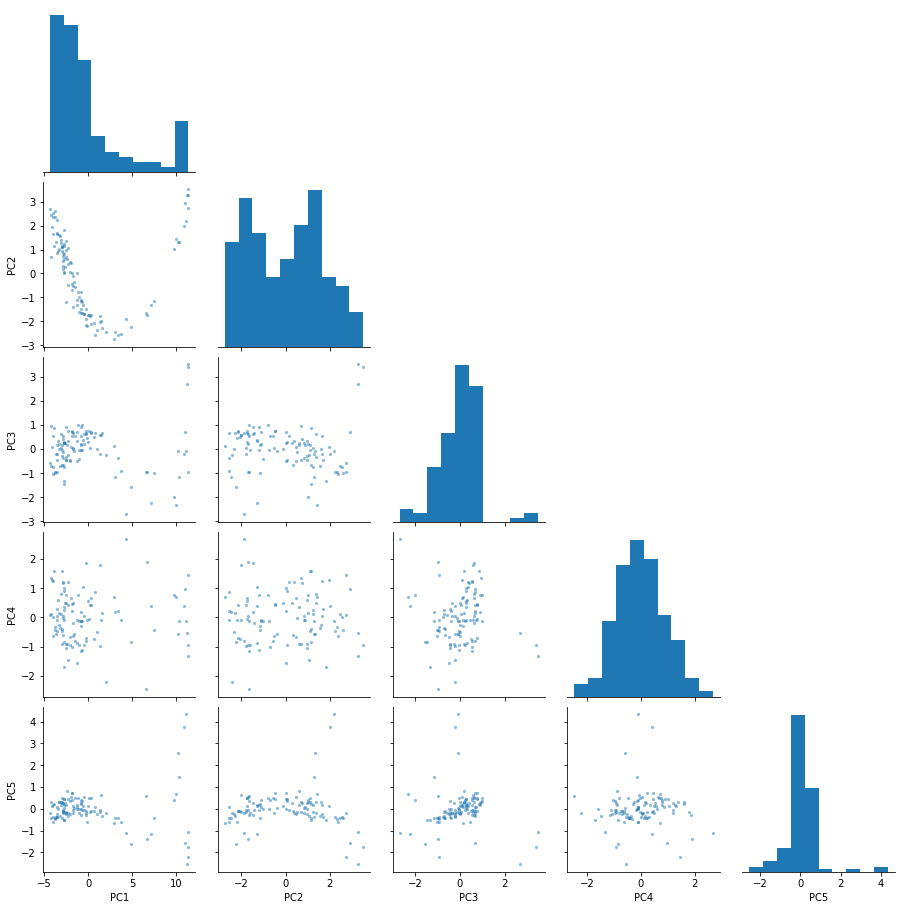

In [12]:
# すべての主成分の組み合わせを見る
sns.pairplot(idea_df_pca, palette="muted", corner=True, plot_kws={"s": 10, "alpha":0.5, "linewidth":0})
plt.show()

In [13]:
# 固有ベクトル（主成分ベクトル）を取り出す
eigenvector_df = pd.DataFrame(pca.components_, columns=list(ideas_df.columns))

# 主成分ベクトル毎に値が大きい上位10件
for i in range(component_num):
    important_aisles = sorted(dict(eigenvector_df.loc[i]).items(), key=lambda x:x[1]**2, reverse=True)[:20]

    print("=" * 10)
    print("第{}主成分".format(i+1))
    print("=" * 10)
    for aisle, score in important_aisles:
        print(aisle, "\t", "{:.3f}".format(score))
    print("")

第1主成分
736 	 -0.138
617 	 0.126
749 	 0.126
579 	 0.116
573 	 -0.103
303 	 -0.101
116 	 0.097
196 	 -0.096
325 	 -0.096
476 	 0.094
379 	 -0.091
766 	 0.091
349 	 0.089
346 	 0.087
211 	 0.086
52 	 -0.084
611 	 0.083
752 	 -0.082
517 	 0.080
646 	 -0.080

第2主成分
386 	 -0.129
565 	 -0.125
617 	 -0.115
512 	 0.109
479 	 -0.103
16 	 0.098
347 	 0.096
529 	 0.093
590 	 -0.093
5 	 0.092
352 	 0.088
593 	 -0.088
755 	 0.086
165 	 0.084
726 	 -0.078
369 	 -0.078
677 	 -0.077
10 	 -0.077
101 	 0.077
459 	 -0.077

第3主成分
96 	 -0.146
242 	 0.125
556 	 -0.106
763 	 -0.101
658 	 0.100
116 	 0.093
285 	 -0.092
439 	 -0.091
648 	 -0.091
82 	 -0.090
600 	 0.089
188 	 0.088
525 	 0.086
84 	 0.084
306 	 -0.084
711 	 0.084
405 	 0.083
538 	 0.083
168 	 -0.082
404 	 0.081

第4主成分
623 	 0.146
1 	 -0.121
424 	 -0.108
259 	 0.107
444 	 -0.104
473 	 0.102
641 	 -0.100
290 	 0.095
258 	 -0.094
30 	 -0.091
256 	 -0.089
251 	 -0.087
523 	 0.086
630 	 0.085
741 	 0.085
346 	 0.082
503 	 -0.082
691 	 -0.082
223 	 -0.

In [14]:
idea_df_pca

,PC1,PC2,PC3,PC4,PC5
0,-1.834161,-0.459049,0.759091,0.465878,0.711257
1,-2.925507,1.131740,-0.665714,-0.403648,-0.413660
2,-2.475664,0.683429,-0.463573,-0.926379,-0.163146
3,1.390674,-2.013708,0.585711,1.782691,-0.157655
4,3.359104,-2.570105,-0.381849,0.211350,-0.423855
...,...,...,...,...,...
106,-0.031396,-1.742883,0.276447,0.545760,0.107242
107,9.906342,1.432511,-2.339827,0.711621,0.670543
108,0.985899,-2.352635,0.014014,-0.513244,-0.257737
109,-2.281305,0.379325,0.343705,1.206640,-0.183262


In [15]:
cluster_num = 5
target_components = [
    'PC1',
    'PC2',
    'PC3', 
    'PC4',
    'PC5',
]

kmeans = KMeans(n_clusters=cluster_num, random_state=0).fit(idea_df_pca[target_components])

# 各アイデアにクラスタIDを割り当て
idea_df_pca['cluster_id'] = kmeans.labels_

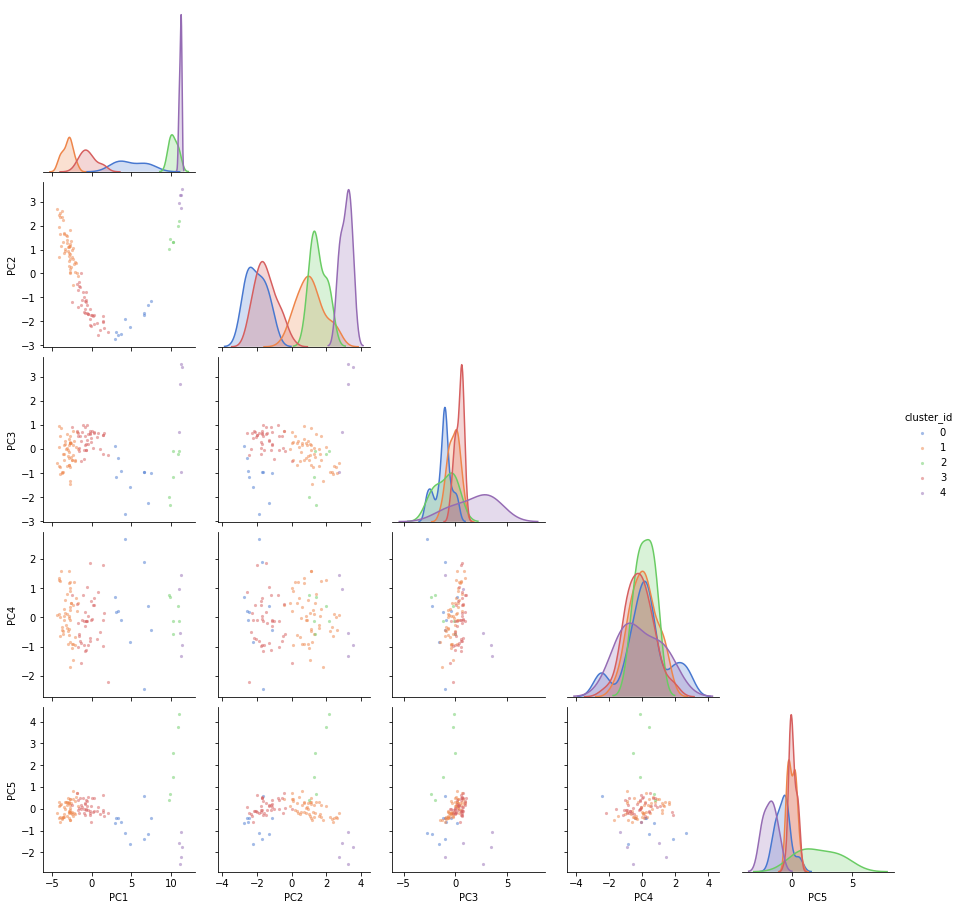

In [18]:
# すべての主成分の組み合わせを見る
sns.pairplot(idea_df_pca, vars=target_components, hue='cluster_id',
             palette="muted", corner=True,
             plot_kws={"s": 10, "alpha":0.5, "linewidth":0})
plt.show()

In [19]:
# クラスタID毎に主成分スコアの平均値を求める
idea_df_pca.groupby(
    'cluster_id'
).mean()

,PC1,PC2,PC3,PC4,PC5
cluster_id,,,,,
0,4.984569,-2.029317,-1.180549,0.221436,-0.724586
1,-3.033537,1.089238,-0.148666,0.080227,0.003601
2,10.354901,1.544287,-0.979949,0.176569,2.194986
3,-0.411068,-1.478375,0.394829,-0.172585,0.076444
4,11.228885,3.140114,1.865061,-0.076338,-1.832373


In [21]:
cluster_centers = kmeans.cluster_centers_
cluster_centers

array([[ 4.9845691e+00, -2.0293174e+00, -1.1805494e+00,  2.2143568e-01,
        -7.2458619e-01],
       [-3.0335371e+00,  1.0892382e+00, -1.4866589e-01,  8.0226764e-02,
         3.6008826e-03],
       [ 1.0354902e+01,  1.5442872e+00, -9.7994876e-01,  1.7656863e-01,
         2.1949859e+00],
       [-4.1106772e-01, -1.4783752e+00,  3.9482924e-01, -1.7258525e-01,
         7.6443985e-02],
       [ 1.1228885e+01,  3.1401145e+00,  1.8650614e+00, -7.6337710e-02,
        -1.8323733e+00]], dtype=float32)

In [22]:
cluster_centers[3]

array([-0.41106772, -1.4783752 ,  0.39482924, -0.17258525,  0.07644399],
      dtype=float32)

In [24]:
test_vectors = vectorizer.vectorize('ペットボトル', "CLS_TOKEN")
test_vectors

/Users/wyuki/opt/anaconda3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1767: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


array([[-0.23342389,  0.1411895 , -0.3511496 , ...,  0.15418975,
        -0.00245479,  0.02360178],
       [-0.55720013, -0.04246628, -0.7720183 , ...,  0.02568977,
        -0.10321629, -0.05446759],
       [-0.3741063 ,  0.43889943, -0.44945735, ...,  0.03427973,
        -0.25591603,  0.24739711],
       [-0.3173198 , -0.0943017 , -0.7234614 , ..., -0.2951774 ,
        -0.27720082,  0.05582178],
       [-0.3741063 ,  0.43889943, -0.44945735, ...,  0.03427973,
        -0.25591603,  0.24739711],
       [-0.21970679, -0.39787206, -0.9306272 , ...,  0.35202864,
        -0.26310134,  0.37626958]], dtype=float32)

In [25]:
cluster_num = 5

kmeans2 = KMeans(n_clusters=cluster_num, random_state=0).fit(ideas_df)
print(kmeans2.labels_)
ideas_df['cluster_id2'] = kmeans2.labels_
cluster_centers2 = kmeans2.cluster_centers_
print(cluster_centers2)

[2 1 1 2 4 2 1 1 1 2 4 1 2 1 4 1 2 3 1 1 1 1 2 2 2 3 1 1 1 1 2 4 4 1 1 2 2
 1 2 1 1 1 1 1 2 2 1 1 1 1 1 1 2 2 1 1 2 1 2 1 2 1 4 1 2 1 4 1 2 2 2 1 1 2
 1 2 2 2 2 3 2 1 0 4 4 4 1 2 0 2 1 0 0 2 0 2 2 1 1 3 1 2 1 2 1 3 2 0 2 1 2]
[[-0.26033354 -0.18136417 -0.51198178 ... -0.18507456  0.04798256
   2.        ]
 [-0.61632955  0.14874562  0.08014448 ... -1.30437194  0.16985358
   1.        ]
 [-0.46362009  0.21761897 -0.03507998 ... -0.96174119  0.13330774
   3.        ]
 [-0.32463222 -0.21325466 -0.40432179 ... -0.06105297 -0.03767228
   4.        ]
 [-0.38915548  0.22627691 -0.3002332  ... -0.45353311  0.18430503
   0.        ]]


In [57]:
ideas_df

,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,cluster_id,cluster_id2
ガンダムみたいな乗り物,-0.678439,-0.037695,0.176766,-0.205148,-0.528620,0.012904,-0.259473,-0.411196,0.124865,0.636233,...,-0.254170,-0.022904,0.141799,-0.451495,-0.320730,-0.251870,-1.182096,0.190484,2,4
美容院,-0.578497,0.268538,-0.025614,-0.188248,-0.391557,0.257790,-0.013212,-0.199921,0.080460,0.714981,...,-0.118479,-0.010099,-0.071062,-0.459137,-0.163989,-0.466344,-1.291615,0.166394,1,1
登り棒,-0.610732,0.372942,-0.017212,-0.170494,-0.414759,-0.033726,-0.057776,-0.166919,0.046035,0.775106,...,-0.043681,-0.017084,-0.041064,-0.592219,-0.191677,-0.446894,-1.267929,0.106272,1,1
ソーシャルディスタンスを保てる,-0.115987,0.203174,-0.112766,-0.277282,-0.145532,-0.091952,-0.162152,-0.077189,0.084245,0.815550,...,-0.231404,0.079771,0.127558,-0.681551,-0.304980,-0.301927,-0.999057,0.162339,2,4
乗った人の犯罪係数がわかる,-0.421841,0.371539,-0.133802,-0.457083,-0.237272,-0.088421,-0.245323,-0.175014,0.045562,0.627234,...,-0.138228,-0.082454,0.057631,-0.703067,0.040711,-0.456272,-0.540399,0.346174,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VR＋BOXの旅行体験トラック,-0.480674,0.098852,-0.147824,-0.403392,-0.576049,-0.018958,-0.022193,-0.222353,-0.201850,0.666717,...,-0.111612,0.207665,0.153238,-0.690601,-0.367504,-0.203137,-0.840727,0.136326,2,4
階段を登るのが楽になる靴や鞄,-0.495703,-0.403826,-0.657971,0.208121,-0.543062,-0.010787,-0.221723,-0.087589,-0.041173,0.051283,...,0.013545,0.059384,-0.039698,0.159748,0.020713,-0.537142,-0.239854,0.071797,0,0
回転寿司が家を通る,-0.409655,0.077903,-0.061166,-0.358645,-0.363210,-0.242739,0.380073,-0.048313,0.243057,0.629835,...,-0.093529,-0.064443,0.189014,-0.687881,0.015266,-0.292500,-0.695504,0.183105,2,4
移動式スーパーマーケット,-0.593653,0.025515,0.171793,-0.105801,-0.596574,-0.048276,0.085725,-0.318745,-0.126261,0.713202,...,-0.046696,0.005708,-0.091670,-0.677027,-0.280556,-0.278404,-1.134773,0.144450,1,1


In [26]:
ideas_df['cluster_id2'].value_counts()




1    50
2    40
4    10
0     6
3     5
Name: cluster_id2, dtype: int64

In [30]:
cluster_dic2 = {0:[], 1:[], 2:[], 3:[], 4:[]}
for column, item in ideas_df['cluster_id2'].iteritems():
    cluster_dic2[item].append(column)
cluster_dic2

{0: ['部屋の中で動きまくるwifi',
  'お父さんお母さんと連携してサンタさん',
  'お母さんの味のuber earts',
  '食べ物じゃなくシェフを運ぶuber earts',
  '出口までお待ちしますをするロボット',
  '階段を登るのが楽になる靴や鞄'],
 1: ['美容院',
  '登り棒',
  '新しいエレベーター',
  '図書館',
  '動くドライブスルー',
  '動く家',
  '着る車',
  'ベッド',
  'イス',
  'タイヤが球体',
  '水陸空両用車',
  '遊牧民',
  'ブレスト車',
  'タイムマシン',
  '動く道路',
  '道路がポイント切り替え',
  '車っぽい買い物袋',
  '消臭車',
  '道路でスキー',
  '人力',
  'UFOキャッチャー',
  'どこでもドア',
  'カラオケ',
  '渋滞の解消',
  'フロントにいろいろ表示',
  'くぐれる',
  'またげる',
  '馬',
  'カスタマイズできる車',
  '外側が液晶画面',
  'ついてくる影',
  'ついてくる傘',
  '折り畳める',
  '着せ替えできる',
  '助手席がDJ',
  '椅子が増える',
  '野生のタクシー',
  'ぽいぽいカプセル',
  'トイレ',
  '窓に電子広告',
  '道路を舗装する車',
  'ウォークスルー',
  'ラウンドアバウト',
  '地上にない道路',
  '動く一軒家',
  '移動式ライブハウス',
  'VRで理想の道路',
  '車の中でVRオフィス',
  '移動式温泉カー',
  '移動式スーパーマーケット'],
 2: ['ガンダムみたいな乗り物',
  'ソーシャルディスタンスを保てる',
  'Wi-Fiと充電機能付き',
  '家から遠隔操作できる車',
  '方向音痴でも運転できる',
  '18歳以下でも運転できる',
  '乗れば空間充電される',
  '無人デリバリー専用車',
  '気まずくならない車',
  '優しい気持ちになれる車',
  '絶対にドライブデートが成功する',
  'しりぞけあう車',
  'ドローンで運ばれる',
  '光の速さで動く',
  '街中ジェットコースター',

In [27]:
ideas_df['cluster_id'].value_counts()

1    50
3    40
0    10
2     6
4     5
Name: cluster_id, dtype: int64

In [31]:
# アイデアで
ideas_df['cluster_id'] = kmeans.labels_

cluster_dic = {0:[], 1:[], 2:[], 3:[], 4:[]}
for column, item in ideas_df['cluster_id'].iteritems():
    cluster_dic[item].append(column)
cluster_dic

{0: ['乗った人の犯罪係数がわかる',
  'いるべき車線がARで表示される',
  'ドラえもんみたいに３mm浮いている',
  '街中の建物にタイヤをつける',
  '自転車についてくる荷物カゴ',
  '夜は荷物うを勝手に運ぶ車',
  '乗った車が自分のものになる',
  '信号機や交差点のいらない自動車',
  '在宅中に確実に届く宅配便',
  '自分のいるところに届く宅配便'],
 1: ['美容院',
  '登り棒',
  '新しいエレベーター',
  '図書館',
  '動くドライブスルー',
  '動く家',
  '着る車',
  'ベッド',
  'イス',
  'タイヤが球体',
  '水陸空両用車',
  '遊牧民',
  'ブレスト車',
  'タイムマシン',
  '動く道路',
  '道路がポイント切り替え',
  '車っぽい買い物袋',
  '消臭車',
  '道路でスキー',
  '人力',
  'UFOキャッチャー',
  'どこでもドア',
  'カラオケ',
  '渋滞の解消',
  'フロントにいろいろ表示',
  'くぐれる',
  'またげる',
  '馬',
  'カスタマイズできる車',
  '外側が液晶画面',
  'ついてくる影',
  'ついてくる傘',
  '折り畳める',
  '着せ替えできる',
  '助手席がDJ',
  '椅子が増える',
  '野生のタクシー',
  'ぽいぽいカプセル',
  'トイレ',
  '窓に電子広告',
  '道路を舗装する車',
  'ウォークスルー',
  'ラウンドアバウト',
  '地上にない道路',
  '動く一軒家',
  '移動式ライブハウス',
  'VRで理想の道路',
  '車の中でVRオフィス',
  '移動式温泉カー',
  '移動式スーパーマーケット'],
 2: ['部屋の中で動きまくるwifi',
  'お父さんお母さんと連携してサンタさん',
  'お母さんの味のuber earts',
  '食べ物じゃなくシェフを運ぶuber earts',
  '出口までお待ちしますをするロボット',
  '階段を登るのが楽になる靴や鞄'],
 3: ['ガンダムみたいな乗り物',
  'ソーシャルディスタンスを保てる',
  'Wi-Fiと充電

In [32]:
#主成分分析したものをクラスタリングするのと，BERTベクトルでクラスタリングするの結果同じだった．．．　BERTのベクトルを圧縮しただけだから同じになる．

In [33]:
#コサイン類似度
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [23]:
#k-meansで分類したクラスタのどれに分類されるか

def k_neareste(new_word_vecs, cluster_centers):
    distance = {}
    c =0
    for center in cluster_centers:
        c += 1
        distance[c] = np.linalg.norm(center-new_word_vecs)
    return min(distance, key=distance.get)
